# 5.0 Structured Research Report Generation

This notebook demonstrates building a sophisticated **multi-agent report generation system** using LangChain 1.0+ and LangGraph 1.0+.

**What you'll learn:**
- Planning agent workflows with structured outputs
- Parallel web research with Tavily Search
- Using `Send()` API for concurrent section writing
- Compiling final reports from multiple sources

This notebook is adapted from [LangChain's Report Maistro](https://github.com/langchain-ai/report-mAIstro).

## Architecture Overview

```
User Input → Report Planner → [Research Agents (parallel)] → [Section Writers (parallel)] → Final Report
```

## Setup

In [1]:
%%capture --no-stderr
%pip install -qU langchain>=1.0.0 langgraph>=1.0.0
%pip install -qU langchain-openai langchain-core
%pip install -qU langchain-tavily  # New: replaces tavily-python for LangChain integration
%pip install -qU tavily-python     # Direct API access

In [2]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGCHAIN_API_KEY")

# Enable LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "structured-research-report"

## Initialize the LLM

Using `init_chat_model` for provider-agnostic model initialization (LangChain 1.0 pattern).

In [3]:
from langchain.chat_models import init_chat_model

# LangChain 1.0 pattern: provider-agnostic initialization
llm = init_chat_model(model="gpt-4o-mini", temperature=0)

# Test the connection
result = llm.invoke("Write a haiku about LangChain.")
print(result.content)

Chains of thought connect,  
Language flows through data streams,  
Wisdom in each link.


## Initialize Tavily Search

We use both the direct Tavily client (for async operations) and the LangChain integration.

In [4]:
from tavily import TavilyClient, AsyncTavilyClient

# Direct Tavily clients for maximum control
tavily_client = TavilyClient()
tavily_async_client = AsyncTavilyClient()

## Define Data Models

Using Pydantic models for structured outputs - a key LangChain 1.0 pattern.

In [5]:
from pydantic import BaseModel, Field
from typing import List, Optional, Literal


class Section(BaseModel):
    """Represents a section of the report."""
    name: str = Field(description="Name for this section of the report.")
    description: str = Field(description="Brief overview of the main topics and concepts to be covered.")
    research: bool = Field(description="Whether to perform web research for this section.")
    content: str = Field(default="", description="The content of the section.")


class Sections(BaseModel):
    """Collection of report sections."""
    sections: List[Section] = Field(description="Sections of the report.")


class SearchQuery(BaseModel):
    """A search query for web research."""
    search_query: str = Field(description="Query for web search.")


class Queries(BaseModel):
    """Collection of search queries."""
    queries: List[SearchQuery] = Field(description="List of search queries.")

## Utility Functions

In [6]:
import asyncio
from langsmith import traceable


def deduplicate_and_format_sources(
    search_response, 
    max_tokens_per_source: int, 
    include_raw_content: bool = True
) -> str:
    """Format and deduplicate search results from Tavily API."""
    # Handle different input formats
    if isinstance(search_response, dict):
        sources_list = search_response.get('results', [])
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response if isinstance(response, list) else [response])
    else:
        raise ValueError("Input must be a dict or list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if isinstance(source, dict) and source.get('url') not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for source in unique_sources.values():
        formatted_text += f"Source {source.get('title', 'Unknown')}:\n===\n"
        formatted_text += f"URL: {source.get('url', '')}\n===\n"
        formatted_text += f"Most relevant content: {source.get('content', '')}\n===\n"
        
        if include_raw_content:
            char_limit = max_tokens_per_source * 4  # ~4 chars per token
            raw_content = source.get('raw_content') or ''
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full content (limited to {max_tokens_per_source} tokens): {raw_content}\n\n"
    
    return formatted_text.strip()


def format_sections(sections: List[Section]) -> str:
    """Format a list of sections into a readable string."""
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description: {section.description}
Requires Research: {section.research}
Content: {section.content if section.content else '[Not yet written]'}

"""
    return formatted_str


@traceable
def tavily_search(query: str) -> dict:
    """Perform a synchronous web search."""
    return tavily_client.search(
        query, 
        max_results=5, 
        include_raw_content=True
    )


@traceable
async def tavily_search_async(
    search_queries: List[str], 
    tavily_topic: str, 
    tavily_days: Optional[int] = None
) -> List[dict]:
    """Perform concurrent web searches."""
    search_tasks = []
    for query in search_queries:
        if tavily_topic == "news":
            task = tavily_async_client.search(
                query,
                max_results=5,
                include_raw_content=True,
                topic="news",
                days=tavily_days
            )
        else:
            task = tavily_async_client.search(
                query,
                max_results=5,
                include_raw_content=True,
                topic="general"
            )
        search_tasks.append(task)
    
    return await asyncio.gather(*search_tasks)

## Define the Report State

Using `TypedDict` for state schemas - the recommended LangGraph 1.0 pattern.

In [7]:
import operator
from typing_extensions import TypedDict, Annotated


class ReportState(TypedDict):
    """Main state for the report generation workflow."""
    topic: str                                          # Report topic
    tavily_topic: Literal["general", "news"]            # Search type
    tavily_days: Optional[int]                          # Days for news search
    report_structure: str                               # Structure guidelines
    number_of_queries: int                              # Queries per section
    sections: List[Section]                             # Planned sections
    completed_sections: Annotated[list, operator.add]   # Completed sections (reducible)
    report_sections_from_research: str                  # Formatted research content
    final_report: str                                   # Final compiled report


class SectionState(TypedDict):
    """State for individual section writing."""
    tavily_topic: Literal["general", "news"]
    tavily_days: Optional[int]
    number_of_queries: int
    section: Section
    search_queries: List[SearchQuery]
    source_str: str
    report_sections_from_research: str
    completed_sections: List[Section]


class SectionOutputState(TypedDict):
    """Output state for section subgraph."""
    completed_sections: List[Section]


class ReportStateOutput(TypedDict):
    """Final output state."""
    final_report: str

## Prompt Templates

In [8]:
# Query generation for planning
REPORT_PLANNER_QUERY_INSTRUCTIONS = """You are an expert technical writer planning a report.

Topic: {topic}
Report Structure: {report_organization}

Generate {number_of_queries} search queries to gather comprehensive information for planning the report sections.

Queries should:
1. Be related to the topic
2. Help satisfy the report organization requirements
3. Be specific enough to find high-quality sources"""

# Section planning
REPORT_PLANNER_INSTRUCTIONS = """You are an expert technical writer planning a report.

Topic: {topic}
Report Structure: {report_organization}
Research Context: {context}

Generate the outline with these fields per section:
- name: Section title
- description: Brief overview of topics to cover
- research: Whether web research is needed (intro/conclusion usually don't need research)
- content: Leave blank for now"""

# Query generation for sections
QUERY_WRITER_INSTRUCTIONS = """Generate targeted web search queries for a technical report section.

Section Topic: {section_topic}

Generate {number_of_queries} queries that:
1. Cover different aspects (features, applications, architecture)
2. Include specific technical terms
3. Target recent information (include year markers like "2024" or "2025")
4. Look for comparisons and differentiators
5. Search official docs and practical examples"""

# Section writing
SECTION_WRITER_INSTRUCTIONS = """You are an expert technical writer crafting one section.

Section Topic: {section_topic}

Guidelines:
1. Technical Accuracy: Include version numbers, metrics, official docs
2. Length: 150-200 words (strict)
3. Structure:
   - Use ## for section title
   - Start with **bold** key insight
   - ONE structural element max (table OR list)
   - End with ### Sources
4. No preamble or marketing language

Source Material:
{context}"""

# Final sections (intro/conclusion)
FINAL_SECTION_INSTRUCTIONS = """You are an expert technical writer crafting a synthesis section.

Section: {section_topic}

Available Report Content:
{context}

For Introduction:
- Use # for title
- 50-100 words
- Clear narrative arc
- NO structural elements

For Conclusion:
- Use ## for title  
- 100-150 words
- Include comparison table for comparative reports
- End with next steps/implications
- NO sources section"""

## Report Planning Node

In [9]:
from langchain_core.messages import HumanMessage, SystemMessage


def invoke_with_retry(structured_llm, messages, max_attempts: int = 3):
    """Retry structured LLM calls to handle occasional failures."""
    for _ in range(max_attempts):
        result = structured_llm.invoke(messages)
        if result:
            return result
    return result


async def generate_report_plan(state: ReportState) -> dict:
    """Generate the report outline with web research."""
    topic = state["topic"]
    report_structure = state["report_structure"]
    number_of_queries = state["number_of_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days")
    
    # Convert structure to string if needed
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)
    
    # Step 1: Generate search queries for planning
    query_llm = llm.with_structured_output(Queries)
    system_msg = REPORT_PLANNER_QUERY_INSTRUCTIONS.format(
        topic=topic,
        report_organization=report_structure,
        number_of_queries=number_of_queries
    )
    
    queries = invoke_with_retry(
        query_llm,
        [SystemMessage(content=system_msg), HumanMessage(content="Generate search queries.")]
    )
    
    # Step 2: Perform web searches
    query_list = [q.search_query for q in queries.queries]
    search_results = await tavily_search_async(query_list, tavily_topic, tavily_days)
    source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000)
    
    # Step 3: Generate section outline
    sections_llm = llm.with_structured_output(Sections)
    system_msg = REPORT_PLANNER_INSTRUCTIONS.format(
        topic=topic,
        report_organization=report_structure,
        context=source_str
    )
    
    sections = invoke_with_retry(
        sections_llm,
        [SystemMessage(content=system_msg), HumanMessage(content="Generate the report sections.")]
    )
    
    return {"sections": sections.sections}

## Section Writing Nodes

In [10]:
def generate_queries(state: SectionState) -> dict:
    """Generate search queries for a section."""
    section = state["section"]
    number_of_queries = state["number_of_queries"]
    
    structured_llm = llm.with_structured_output(Queries)
    system_msg = QUERY_WRITER_INSTRUCTIONS.format(
        section_topic=section.description,
        number_of_queries=number_of_queries
    )
    
    queries = invoke_with_retry(
        structured_llm,
        [SystemMessage(content=system_msg), HumanMessage(content="Generate search queries.")]
    )
    
    return {"search_queries": queries.queries}


async def search_web(state: SectionState) -> dict:
    """Search the web for section content."""
    search_queries = state["search_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days")
    
    query_list = [q.search_query for q in search_queries]
    search_results = await tavily_search_async(query_list, tavily_topic, tavily_days)
    source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=5000)
    
    return {"source_str": source_str}


def write_section(state: SectionState) -> dict:
    """Write a section based on research."""
    section = state["section"]
    source_str = state["source_str"]
    
    system_msg = SECTION_WRITER_INSTRUCTIONS.format(
        section_topic=section.description,
        context=source_str
    )
    
    content = llm.invoke([
        SystemMessage(content=system_msg),
        HumanMessage(content="Write the section based on the sources.")
    ])
    
    section.content = content.content
    return {"completed_sections": [section]}

## Build the Section Subgraph

/var/folders/5l/y8s3fc655417629rqwgxkhx80000gn/T/ipykernel_25342/2994856846.py:5: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  section_builder = StateGraph(SectionState, output=SectionOutputState)


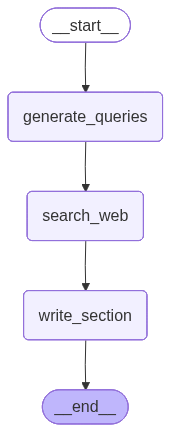

In [11]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

# Build section writing subgraph
section_builder = StateGraph(SectionState, output=SectionOutputState)

section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)

section_graph = section_builder.compile()

display(Image(section_graph.get_graph(xray=1).draw_mermaid_png()))

## Define the Report Structure

In [12]:
REPORT_STRUCTURE = """This report focuses on comparative analysis.

Structure:
1. Introduction (no research needed)
   - Overview of the topic
   - Context for comparison

2. Main Body Sections:
   - One section per item being compared
   - Each section covers:
     * Core Features (bulleted list)
     * Architecture & Implementation (2-3 sentences)
     * Example use case (2-3 sentences)

3. Conclusion with Comparison Table (no research needed)
   - Comparison table across key dimensions
   - Strengths and weaknesses
   - Final recommendations"""

## Test Section Generation

In [13]:
# Define a test topic
report_topic = "Comparison of AI agent frameworks: LangChain, CrewAI, and AutoGen"

# Generate the plan first
sections_result = await generate_report_plan({
    "topic": report_topic,
    "report_structure": REPORT_STRUCTURE,
    "number_of_queries": 3,
    "tavily_topic": "general",
    "tavily_days": None
})

# Display the planned sections
for section in sections_result["sections"]:
    print(f"{'='*50}")
    print(f"Name: {section.name}")
    print(f"Description: {section.description}")
    print(f"Research: {section.research}")

Name: Introduction
Description: This section provides an overview of the comparative analysis of AI agent frameworks, specifically LangChain, CrewAI, and AutoGen. It sets the context for the comparison by highlighting the importance of selecting the right framework for developing AI agents.
Research: False
Name: LangChain
Description: This section covers the core features of LangChain, its architecture and implementation, and provides an example use case to illustrate its application.
Research: True
Name: CrewAI
Description: This section discusses the core features of CrewAI, its architecture and implementation, and presents an example use case to demonstrate its functionality.
Research: True
Name: AutoGen
Description: This section outlines the core features of AutoGen, its architecture and implementation, and includes an example use case to showcase its capabilities.
Research: True
Name: Conclusion
Description: This section summarizes the findings from the comparative analysis, presen

In [14]:
# Test with one section that requires research
test_section = next(s for s in sections_result["sections"] if s.research)
print(f"Testing with section: {test_section.name}")

result = await section_graph.ainvoke({
    "section": test_section,
    "number_of_queries": 2,
    "tavily_topic": "general",
    "tavily_days": None
})

# Display the result
from IPython.display import Markdown
Markdown(result["completed_sections"][0].content)

Testing with section: LangChain


## Core Features of LangChain

**LangChain provides a robust framework for building stateful, long-running agents.** Its architecture is designed around a graph-based structure that supports complex workflows, enabling developers to create dynamic applications with features such as durable execution, human-in-the-loop capabilities, and comprehensive memory management.

Key features include:

- **Durable Execution**: Agents can persist through failures and resume from their last state, ensuring reliability in long-running tasks.
- **Human-in-the-Loop**: This feature allows for real-time human oversight, enabling modifications to agent states during execution.
- **Memory Management**: LangChain supports both short-term and long-term memory, allowing agents to retain context across sessions.
- **Streaming and Interrupts**: Agents can handle streaming data and interruptions, enhancing their responsiveness and adaptability.

### Example Use Case

A practical application of LangChain could be a customer support chatbot that utilizes its memory capabilities to remember user preferences and past interactions, providing a personalized experience. The chatbot can also incorporate human feedback during complex queries, ensuring high-quality responses.

### Sources
- [LangChain Documentation](https://docs.langchain.com/oss/javascript/langgraph/overview)
- [LangGraph Overview](https://docs.langchain.com/oss/javascript/langgraph/overview)
- [Persistence in LangGraph](https://docs.langchain.com/oss/python/langgraph/persistence)

## Build the Full Report Graph

Using LangGraph's `Send()` API to parallelize section writing.

In [15]:
from langgraph.constants import Send


def initiate_section_writing(state: ReportState):
    """Kick off parallel research for sections that need it."""
    return [
        Send("build_section_with_web_research", {
            "section": s,
            "number_of_queries": state["number_of_queries"],
            "tavily_topic": state["tavily_topic"],
            "tavily_days": state.get("tavily_days")
        })
        for s in state["sections"]
        if s.research
    ]


def gather_completed_sections(state: ReportState) -> dict:
    """Format completed research sections."""
    completed_sections = state["completed_sections"]
    formatted = format_sections(completed_sections)
    return {"report_sections_from_research": formatted}


def write_final_sections(state: SectionState) -> dict:
    """Write intro/conclusion sections using research context."""
    section = state["section"]
    context = state["report_sections_from_research"]
    
    system_msg = FINAL_SECTION_INSTRUCTIONS.format(
        section_topic=section.description,
        context=context
    )
    
    content = llm.invoke([
        SystemMessage(content=system_msg),
        HumanMessage(content="Write the section.")
    ])
    
    section.content = content.content
    return {"completed_sections": [section]}


def initiate_final_section_writing(state: ReportState):
    """Kick off parallel writing for non-research sections."""
    return [
        Send("write_final_sections", {
            "section": s,
            "report_sections_from_research": state["report_sections_from_research"]
        })
        for s in state["sections"]
        if not s.research
    ]


def compile_final_report(state: ReportState) -> dict:
    """Assemble the final report in order."""
    sections = state["sections"]
    completed = {s.name: s.content for s in state["completed_sections"]}
    
    # Update sections with completed content
    for section in sections:
        section.content = completed.get(section.name, section.content)
    
    # Compile in original order
    final_report = "\n\n".join(s.content for s in sections if s.content)
    return {"final_report": final_report}

/var/folders/5l/y8s3fc655417629rqwgxkhx80000gn/T/ipykernel_25342/968503732.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [16]:
# Build the full report graph
builder = StateGraph(ReportState, output=ReportStateOutput)

# Add nodes
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("build_section_with_web_research", section_graph)
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

# Add edges
builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges(
    "generate_report_plan",
    initiate_section_writing,
    ["build_section_with_web_research"]
)
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges(
    "gather_completed_sections",
    initiate_final_section_writing,
    ["write_final_sections"]
)
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

# Compile
report_graph = builder.compile()

/var/folders/5l/y8s3fc655417629rqwgxkhx80000gn/T/ipykernel_25342/4080881765.py:2: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(ReportState, output=ReportStateOutput)


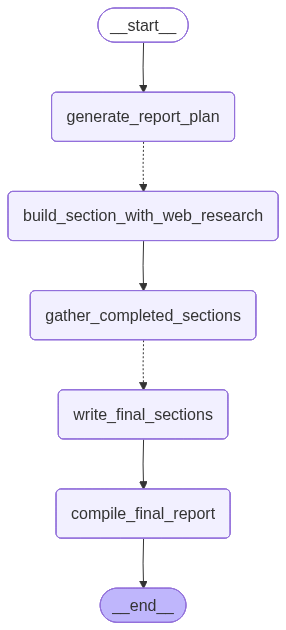

In [17]:
# Visualize the graph
display(Image(report_graph.get_graph().draw_mermaid_png()))

## Generate a Full Report

In [18]:
# Generate a full report
report_topic = "Comparison of AI coding assistants: GitHub Copilot, Cursor, and Claude Code"

report = await report_graph.ainvoke({
    "topic": report_topic,
    "report_structure": REPORT_STRUCTURE,
    "number_of_queries": 2,
    "tavily_topic": "general",
    "tavily_days": None
})

In [19]:
# Display the final report
from IPython.display import Markdown
Markdown(report["final_report"])

# Overview of AI Coding Assistants and the Need for Comparison Among GitHub Copilot, Cursor, and Claude Code

As the demand for efficient coding solutions grows, AI coding assistants have emerged as vital tools for developers. GitHub Copilot, Cursor, and Claude Code each offer unique features and capabilities that enhance productivity and streamline the coding process. Understanding the distinctions among these tools is essential for developers seeking to optimize their workflows. This synthesis will explore the core functionalities, architectures, and practical applications of each assistant, providing a comprehensive comparison to guide users in selecting the most suitable option for their needs.

## Conclusion

In comparing GitHub Copilot, Cursor, and Claude Code, we can identify key differences in their features, architectures, and use cases. GitHub Copilot excels in IDE integration and unit test generation, while Cursor offers a chat interface and dynamic code optimization. Claude Code stands out with its command-line interface and advanced data analysis capabilities. 

| Feature/Tool       | GitHub Copilot         | Cursor                  | Claude Code             |
|--------------------|------------------------|-------------------------|-------------------------|
| Integration         | IDEs (VS Code, JetBrains) | Standalone (VS Code fork) | CLI with various tools   |
| Key Features        | Code suggestions, Copilot Chat | Autocomplete, Documentation support | File access, Agent skills |
| Use Case            | Automating unit tests  | Creating landing pages   | Automating data analysis  |

As developers continue to explore AI-driven solutions, the choice of coding assistant will depend on specific project requirements and personal preferences. Future research should focus on user experiences and performance metrics to further inform these decisions.

## Analysis of GitHub Copilot

**GitHub Copilot enhances developer productivity by 20-30% through intelligent code suggestions and seamless integration with popular IDEs.** Launched in 2022, it leverages OpenAI's Codex model to provide contextual code completions, documentation, and even unit tests. Key features include code suggestions, Copilot Chat for interactive assistance, and the ability to generate pull requests autonomously.

The architecture of GitHub Copilot is built on a large language model (LLM) that analyzes the context of the code being written, allowing it to suggest relevant snippets. It integrates with various IDEs, including Visual Studio Code and JetBrains, and supports multiple programming languages. The tool can also learn from the user's codebase, improving its suggestions over time.

### Example Use Case: Automating Unit Test Generation

A developer can prompt Copilot to generate unit tests for a function by simply typing a comment like `// generate unit tests for this function`. Copilot will then produce a set of relevant test cases, significantly reducing the time spent on writing tests manually. This capability not only accelerates the development process but also enhances code quality by ensuring comprehensive test coverage.

### Sources
- [GitHub Copilot Features](https://docs.github.com/en/copilot/get-started/features)
- [What's New with GitHub Copilot: July 2024](https://github.blog/ai-and-ml/github-copilot/whats-new-with-github-copilot-july-2024/)
- [GitHub Copilot Review](https://www.apriorit.com/dev-blog/github-copilot-review)

## Examination of Cursor

**Cursor is an AI-powered code editor that enhances coding efficiency through intelligent features.** Built on a fork of Visual Studio Code, Cursor integrates advanced AI capabilities, including code suggestions, error detection, and dynamic optimization. As of October 2025, the latest version is 1.6, which includes significant improvements in user experience and functionality.

### Core Features
- **AI Integration**: Utilizes models like OpenAI's ChatGPT and Claude 3.5 Sonnet for intelligent code suggestions.
- **Autocomplete**: Predicts multi-line edits and adjusts based on recent changes.
- **Chat Interface**: Allows users to interact with the codebase, ask questions, and receive context-aware responses.
- **Documentation Support**: Users can add documentation references for quick access to library information.

### Architecture
Cursor operates as a standalone application, leveraging the VS Code ecosystem while optimizing for AI-driven features. It supports various programming languages and integrates seamlessly with existing development tools.

### Practical Example
In a real-world scenario, a developer can use Cursor to create a basic landing page by simply typing a prompt in the chat interface. The AI generates the necessary code, modifies existing files, and even troubleshoots issues, significantly speeding up the development process.

### Sources
- [Cursor AI: A Guide With 10 Practical Examples](https://www.datacamp.com/tutorial/cursor-ai-code-editor)
- [Cursor AI Tutorial for Beginners [2025 Edition]](https://www.youtube.com/watch?v=3289vhOUdKA)
- [Realworld Example of Cursor AI](https://medium.com/realworld-ai-use-cases/realworld-example-of-cursor-ai-a-system-to-help-run-my-companys-finances-c42144f1ea81)

## Discussion of Claude Code

**Claude Code is a versatile AI coding assistant designed to enhance developer productivity.** It operates through a command-line interface (CLI) and integrates with various development environments, allowing users to generate, modify, and analyze code using natural language. Key features include the ability to access local files, execute code, and manage subagents for complex workflows.

### Core Features
- **Command-Line Interface (CLI):** Facilitates direct interaction with the user's computer, enabling file access and execution of commands.
- **Integration with Tools:** Connects with APIs and platforms like Benchling and 10x Genomics, streamlining data analysis and research workflows.
- **Agent Skills:** Utilizes predefined protocols for specific tasks, enhancing its ability to perform complex operations autonomously.

### Architecture
Claude Code is built on the Sonnet 4.5 model, which has been fine-tuned for scientific and technical tasks. It boasts a context window of 200,000 tokens, allowing it to handle extensive data inputs and maintain coherence across lengthy interactions. This architecture supports advanced reasoning and contextual understanding, making it suitable for intricate coding tasks.

### Use Case
In the life sciences, Claude Code can automate data analysis pipelines, generate scientific reports, and assist in regulatory document drafting. For instance, it can analyze genomic data and produce visualizations, significantly reducing the time required for such tasks from months to mere days.

### Sources
- [Claude Code in Life Sciences: Practical Applications Guide](https://intuitionlabs.ai/articles/claude-code-life-science-applications)
- [5 Powerful Claude Code Use Cases You Probably Didn't Know About](https://www.thepromptwarrior.com/p/5-powerful-claude-code-use-cases-you-probably-didn-t-know-about-5826bfb7f5b8fdd8)
- [How AI Is Transforming Work at Anthropic](https://www.anthropic.com/research/how-ai-is-transforming-work-at-anthropic)

# Summary of Findings

In this synthesis, we evaluate three prominent AI coding assistants: GitHub Copilot, Cursor, and Claude Code. Each tool offers unique features and capabilities that cater to different aspects of software development. GitHub Copilot excels in enhancing productivity through intelligent code suggestions and seamless IDE integration. Cursor stands out with its chat interface and dynamic optimization, making it user-friendly for developers. Claude Code, with its command-line interface and advanced reasoning capabilities, is particularly suited for complex scientific and technical tasks. 

| AI Coding Assistant | Strengths | Weaknesses |
|---------------------|-----------|------------|
| GitHub Copilot      | - Increases productivity by 20-30%<br>- Contextual code completions<br>- Autonomously generates pull requests | - Limited to IDEs and may not suit all workflows |
| Cursor              | - User-friendly chat interface<br>- Predicts multi-line edits<br>- Integrates well with existing tools | - May lack advanced features for complex tasks |
| Claude Code         | - Handles extensive data inputs<br>- Suitable for scientific applications<br>- Executes commands directly | - CLI may be less intuitive for some users |

## Conclusion

In conclusion, the choice of an AI coding assistant should align with the specific needs of the development team. GitHub Copilot is ideal for those seeking productivity boosts in traditional coding environments, while Cursor offers a more interactive experience for general coding tasks. Claude Code is best suited for users in scientific fields requiring advanced data analysis capabilities. As organizations continue to adopt AI tools, evaluating these options will be crucial for optimizing development workflows and enhancing overall efficiency. Next steps involve assessing team requirements and conducting trials to determine the best fit for individual projects.

In [20]:
# Print as plain text if preferred
print(report["final_report"])

# Overview of AI Coding Assistants and the Need for Comparison Among GitHub Copilot, Cursor, and Claude Code

As the demand for efficient coding solutions grows, AI coding assistants have emerged as vital tools for developers. GitHub Copilot, Cursor, and Claude Code each offer unique features and capabilities that enhance productivity and streamline the coding process. Understanding the distinctions among these tools is essential for developers seeking to optimize their workflows. This synthesis will explore the core functionalities, architectures, and practical applications of each assistant, providing a comprehensive comparison to guide users in selecting the most suitable option for their needs.

## Conclusion

In comparing GitHub Copilot, Cursor, and Claude Code, we can identify key differences in their features, architectures, and use cases. GitHub Copilot excels in IDE integration and unit test generation, while Cursor offers a chat interface and dynamic code optimization. Claude

## Summary

In this notebook, you learned:

1. **Structured Outputs**: Using Pydantic models with `llm.with_structured_output()` for reliable data extraction
2. **Subgraphs**: Composing complex workflows from smaller, reusable graph components
3. **Parallel Execution**: Using LangGraph's `Send()` API to process sections concurrently
4. **State Management**: Using `TypedDict` with reducers (like `operator.add`) for accumulating results
5. **Async Search**: Leveraging `asyncio.gather()` for concurrent web searches

### Key LangChain 1.0 Patterns Used

| Pattern | Example |
|---------|--------|
| Provider-agnostic init | `init_chat_model(model="gpt-4o-mini")` |
| Structured outputs | `llm.with_structured_output(Sections)` |
| TypedDict state | `class ReportState(TypedDict)` |
| Tavily integration | Direct `TavilyClient` + async support |